<a href="https://colab.research.google.com/github/GigiQR99/CV-Class3-Streamlit/blob/main/NLP_WK4_Spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords


# Load the data
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/train.csv"
df = pd.read_csv(url)

print(df.head(3).to_string())
print(df.isnull().sum())

                                                                                                                                                             sms  label
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n      0
1                                                                                                                                Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n      1
sms      0
label    0
dtype: int64


## Text Preprocessing

In [ ]:
def simple_preprocess(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = ' '.join(text.split())

    return text

def combine_text_fields(row):
    title = simple_preprocess(str(row.get('title', '')))
    text = simple_preprocess(str(row.get('text', '')))

    combined = f"{title} {text}".strip()
    return combined if combined else "empty"

# Combine text fields
# df['combined_text'] = df.apply(combine_text_fields, axis=1)

# Clean up labels
# df['label'] = df['type'].str.lower().str.strip()

# Remove any rows with invalid labels or empty text
df = df.dropna(subset=['label', 'sms'])
df = df[df['sms'] != 'empty']

In [ ]:
df.head(3)

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


## Vectorization and Training

In [ ]:
# Prepare
X = df['sms'].values
y = df['label'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Fit and transform
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Train model
model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_tfidf, y_train)   # Trained it right here

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## Evaluation

Test Accuracy: 0.9767 (97.67%)
Classification Report:
              precision    recall  f1-score   support

           0     0.9906    0.9824    0.9865       966
           1     0.8917    0.9396    0.9150       149

    accuracy                         0.9767      1115
   macro avg     0.9412    0.9610    0.9508      1115
weighted avg     0.9774    0.9767    0.9769      1115



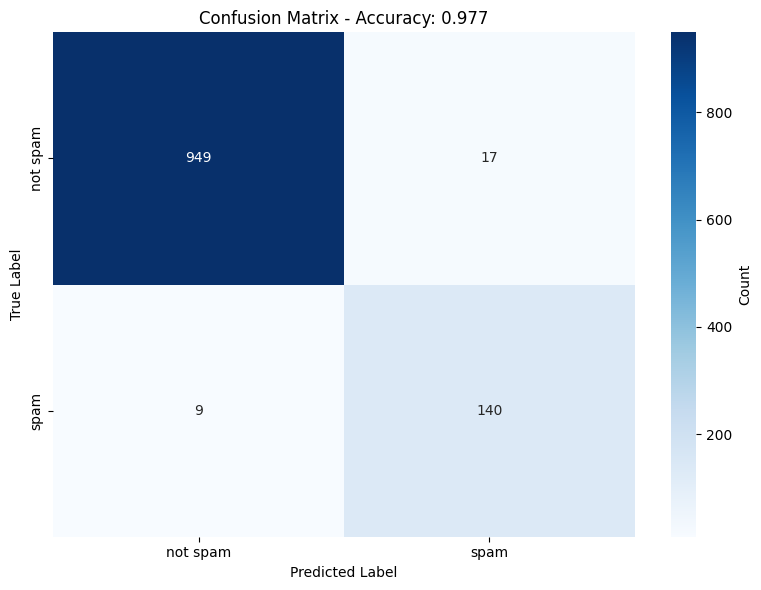

In [ ]:
# Make predictions
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print(f"Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
labels = ['not spam', 'spam']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.3f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Feature Analysis

In [ ]:
# feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

# Top spam indicators (positive coefficients)
top_spam_idx = np.argsort(coefficients)[-15:]
top_spam_features = [(feature_names[i], coefficients[i]) for i in top_spam_idx]
top_spam_features.reverse()

# print some top indicators
print(f"positive coefficients:")
for i, (feature, coef) in enumerate(top_spam_features, 1):
    print(f"{i:2d}. {feature:<20} (coef: {coef:.4f})")

# Top non-spam indicators
top_notspam_idx = np.argsort(coefficients)[:15]
top_notspam_features = [(feature_names[i], coefficients[i]) for i in top_notspam_idx]

print(f"negative coefficients:")
for i, (feature, coef) in enumerate(top_notspam_features, 1):
    print(f"{i:2d}. {feature:<20} (coef: {coef:.4f})")

positive coefficients:
 1. txt                  (coef: 4.7738)
 2. mobile               (coef: 4.0908)
 3. claim                (coef: 3.9082)
 4. uk                   (coef: 3.8896)
 5. free                 (coef: 3.8163)
 6. www                  (coef: 3.5994)
 7. reply                (coef: 3.4954)
 8. stop                 (coef: 3.3127)
 9. 150p                 (coef: 3.1896)
10. text                 (coef: 3.1637)
11. prize                (coef: 3.0529)
12. service              (coef: 3.0184)
13. new                  (coef: 2.9342)
14. com                  (coef: 2.9265)
15. won                  (coef: 2.8426)
negative coefficients:
 1. ok                   (coef: -2.2986)
 2. ll                   (coef: -2.0359)
 3. da                   (coef: -1.8269)
 4. home                 (coef: -1.7548)
 5. gt                   (coef: -1.7153)
 6. got                  (coef: -1.7042)
 7. lt                   (coef: -1.6955)
 8. come                 (coef: -1.6761)
 9. good                 (

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# Your existing preprocessing code
X = df['sms'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Define multiple models
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),

    'Naive Bayes': MultinomialNB(
        alpha=0.1
    ),

    'SVM': SVC(
        kernel='linear',
        class_weight='balanced',
        probability=True,
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),

    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),

    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    )
}

# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Track training time
    start_time = time.time()

    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    train_time = time.time() - start_time

    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'train_time': train_time,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    print(f"✓ {name}: Accuracy = {accuracy:.4f}, Time = {train_time:.2f}s")

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision (spam)': [results[m]['classification_report']['1']['precision'] for m in results],
    'Recall (spam)': [results[m]['classification_report']['1']['recall'] for m in results],
    'F1 (spam)': [results[m]['classification_report']['1']['f1-score'] for m in results],
    'Training Time (s)': [results[m]['train_time'] for m in results]
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

# Get the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name}")

# Detailed report for best model
print(f"\nDetailed Report for {best_model_name}:")
print(classification_report(y_test, results[best_model_name]['predictions']))


Training Logistic Regression...
✓ Logistic Regression: Accuracy = 0.9767, Time = 0.05s

Training Naive Bayes...
✓ Naive Bayes: Accuracy = 0.9848, Time = 0.01s

Training SVM...
✓ SVM: Accuracy = 0.9821, Time = 5.66s

Training Random Forest...
✓ Random Forest: Accuracy = 0.9767, Time = 2.43s

Training Gradient Boosting...
✓ Gradient Boosting: Accuracy = 0.9677, Time = 3.04s

Training K-Nearest Neighbors...
✓ K-Nearest Neighbors: Accuracy = 0.9453, Time = 0.19s

MODEL COMPARISON
              Model  Accuracy  Precision (spam)  Recall (spam)  F1 (spam)  Training Time (s)
        Naive Bayes  0.984753          0.971429       0.912752   0.941176           0.005138
                SVM  0.982063          0.944828       0.919463   0.931973           5.655041
Logistic Regression  0.976682          0.891720       0.939597   0.915033           0.053854
      Random Forest  0.976682          1.000000       0.825503   0.904412           2.427175
  Gradient Boosting  0.967713          0.982906      

## Simple Prediction Function

In [ ]:
def predict_spam(text):
    # Preprocess
    processed_text = simple_preprocess(text)

    # Vectorize
    text_tfidf = tfidf.transform([processed_text])

    # Predict
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    spam_prob = probability[1] if model.classes_[1] == 'spam' else probability[0]

    return {
        'prediction': prediction,
        'spam_probability': spam_prob,
        'confidence': max(probability)
    }



# Test examples
test_examples = [
    "URGENT: You've won $1000! Click here to claim now!",
    "Hi Dr. LLee, let's schedule our meeting for tomorrow at 2 PM",
    "FREE MONEY! Make $500 per day!",
    "Your order #12345 has been shipped and will arrive tomorrow",
    "Congratulations! You're pre-approved for a $50,000 loan!"
]

for i, text in enumerate(test_examples, 1):
    result = predict_spam(text)

    print(f"\n{i}. Text: \"{text[:60]}{'...' if len(text) > 60 else ''}\"")
    print(f"   Prediction: {result['prediction'].upper()}")
    print(f"   Spam Probability: {result['spam_probability']:.3f}")
    print(f"   Confidence: {result['confidence']:.3f}")


1. Text: "URGENT: You've won $1000! Click here to claim now!"


AttributeError: 'numpy.int64' object has no attribute 'upper'